# osu! Beatmaps Failtimes Prediction
**Contributors:** Sophie Yun, Emily Gong, Sine Polcharoen

# Introduction

**Our Problem:** Beatmaps in OSU differ in their difficulties. Currently, there is a difficulty rating for each beatmap proposed by OSU, but players feel that it is not accurate because it is largely based on overall measurements of each beatmap. Intuitively speaking, if two beatmaps have the same number of notes, but one has most of the notes in the first minute, and the other one has notes evenly spread across the song, then the first one is definitely harder. Also, a beatmap with players who usually fail at the very end is different from a beatmap with players who usually fail at the very beginning. What we propose here is to take a different approach by breaking down each beatmap to multiple sections and looking at the data within each section, instead of just checking the overall data.

In our project, we predicted failtimes by looking at measurements of each hit object within a certain time interval. This should provide a more accurate estimation than the current difficulty rating system. This can also be helpful in predicting other metrics, such as performance points. All these come down to encourage head developers to collect more specific data and therefore to create better beatmaps that are tailored to players at different skill levels.


**Our Data:** In the original data source, each **beatmap** is divided into 100 intervals / chunks and **failtimes** indicates the number of players failed at each interval. The **failtimes** and the **hit objects** are closely correlated because missing **hit objects** decrease one's health bar, which ultimately leads to 'game over'. 
* Types of **hit obejcts**: hit circle, slider, spinner
    * hit circle: repeat_count = 0
    * slider: repeat_count >= 1
    * spinner: not discussed

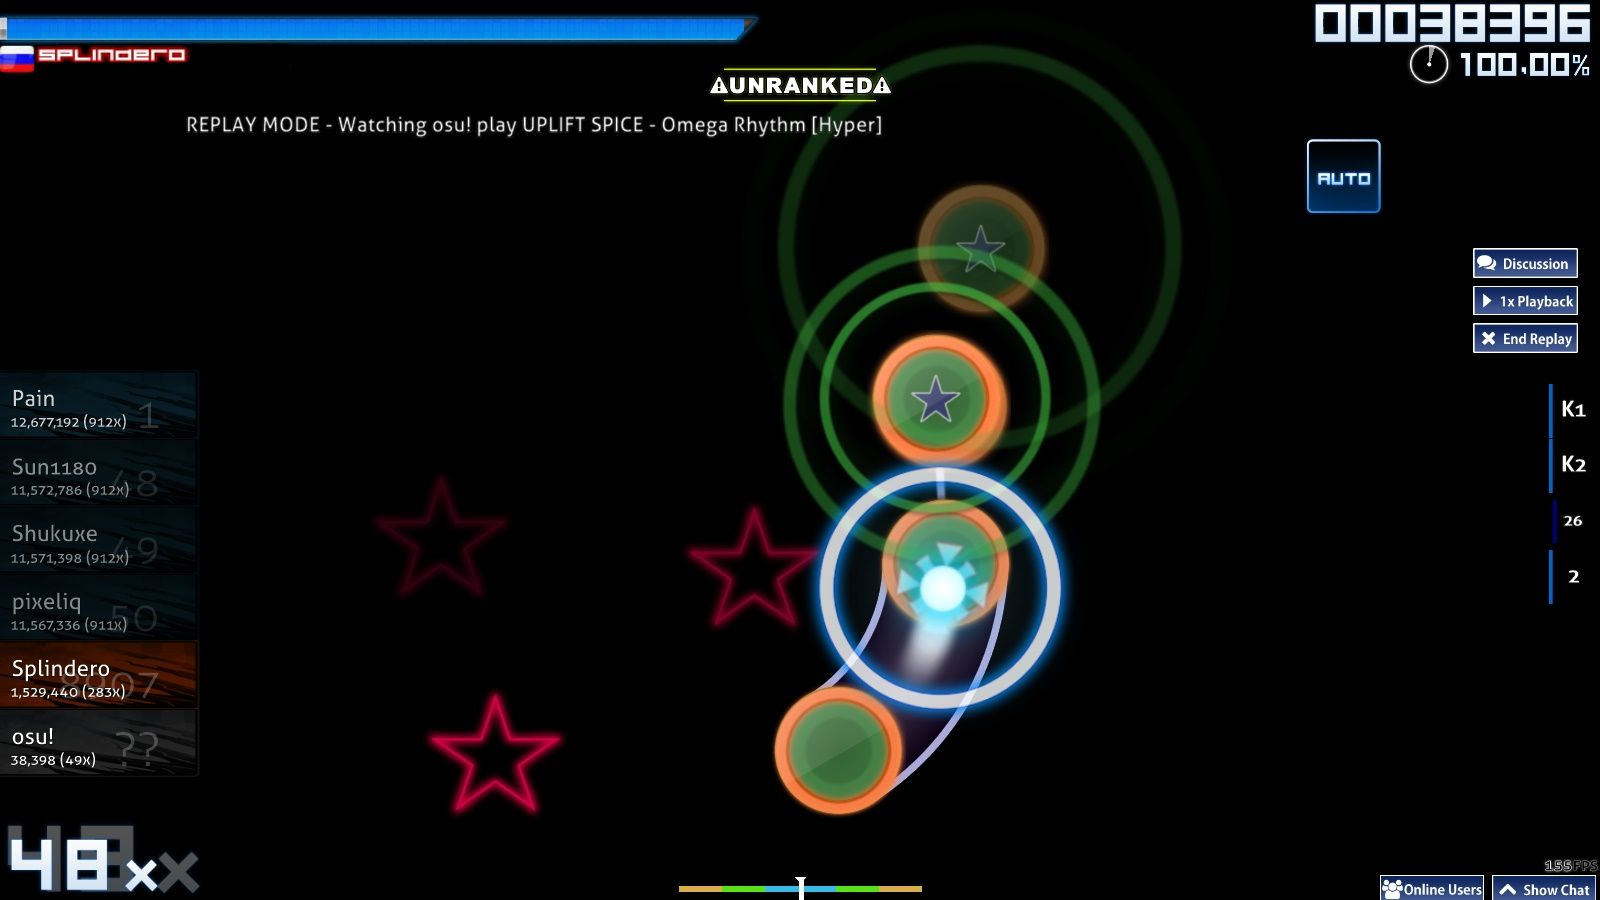

* Unit: all times are in milliseconds

**Our Goal:** By extracting all the attributes about **hit objects**, which include locations (x, y, x1, y1), repeat_count, duration, d_time, and time, we hope to predict **failtimes** for some of the most popular **beatmaps** in the osu! system.

# Data Retrieval

## Packages

In [1]:
import sys
sys.path.append('../..')
import pandas as pd
import numpy as np
from config import client
import seaborn as sns 
import matplotlib.pyplot as plt
import pylab 

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
import scipy.stats as stats

from preliminary_modeling_failtimes import Xgboost_est_pp_model
from failtimes_functions import CREATE_ARRAY_FOR_MODEL, CREATE_COORDINATES_DIST_ARRAY_FOR_MODEL, CREATE_EASY_DF, CREATE_PARTITION_DF

## Connecting to MongoDB

In [2]:
db = client["osu_mlpp_db1"]
new_beatmaps = list(db.osu_beatmaps.find({"difficultyrating" : {"$gte": 1.5, "$lt": 2}}, 
                                         {"_id" : 1, "mlpp.hit_objects": 1, "mlpp.fail" : 1, 
                                          "difficultyrating" : 1, "playcount": 1, 
                                          "total_length": 1}).limit(500))

We retrieved data on 500 beatmaps with a difficulty rating of 1.5 to 2. These beatmaps are on the easier side, so there will be greater amount of players attempting to play them. This means that we will have a more hollistic data set, covering players of various player levels. For our model, we do not want a large amount of higher-level players, because that could heavily skew our model.

## Data Processing

### 1. By Time Intervals

In [3]:
#remove hit_objects = none
for bm in new_beatmaps:
    if bm["mlpp"]["hit_objects"] == None:
        new_beatmaps.remove(bm)
    if bm["mlpp"]["fail"] == None:
        new_beatmaps.remove(bm)

In [4]:
# The first beatmap
hit_objects_colnames = ["x","y","x1","y1","repeat_count","duration", "d_time","time"]

new_df = pd.DataFrame(new_beatmaps[0]["mlpp"]["hit_objects"], 
                  columns = hit_objects_colnames)
new_df

,x,y,x1,y1,repeat_count,duration,d_time,time
0,64,320,64,320,1,0,5538,5538
1,64,192,64,192,1,0,697,6235
2,64,64,64,64,1,0,698,6933
3,448,64,448,64,1,0,1395,8328
4,448,192,448,192,1,0,698,9026
...,...,...,...,...,...,...,...,...
78,256,32,256,312,3,697,697,76700
79,64,64,64,64,1,0,2094,79491
80,160,64,440,258,1,1046,698,80189
81,448,160,448,160,1,0,349,81584


#### Create a dataframe for all beatmaps (CREATE_EASY_DF)
* Each row represents one hundredth of the beatmap in time
* failtimes_norm: failtimes / play counts
* coord_dist_sum: sum of distance between (x1, y1) and (x, y) for all hit objects in each time interval
* repeat_count_sum: sum of number of movements ...
    * i.e., a hit circle gets 0, a slider that moves from one location to another gets 1
* duration_sum: sum of duration (time to complete a hitting motion) ...
    * i.e., a hit circle gets 0, a slider gets some greater positive number)
* d_time_avg: average time of time difference between the previous object and the current object ...

#### Helper Functions within CREATE_EASY_DF
* CREATE_COORDINATES_DIST_ARRAY_FOR_MODEL: calculate the distance given coordinates input
* CREATE_ARRAY_FOR_MODEL: summing / averaging hit objects' information

In [8]:
# 500 beatmaps
easy_df = CREATE_EASY_DF(new_beatmaps, hit_objects_colnames)
easy_df

,time,failtimes,failtimes_norm,coord_dist_sum,repeat_count_sum,duration_sum,d_time_avg
0,822.82,0,0.000000,0.0,0,0,0.000000
1,1645.64,0,0.000000,0.0,0,0,0.000000
2,2468.46,0,0.000000,0.0,0,0,0.000000
3,3291.28,0,0.000000,0.0,0,0,0.000000
4,4114.10,0,0.000000,0.0,0,0,0.000000
...,...,...,...,...,...,...,...
49995,76861.44,127,0.001172,0.0,0,0,0.000000
49996,77662.08,62,0.000572,0.0,0,0,0.000000
49997,78462.72,125,0.001154,0.0,3,0,322.666667
49998,79263.36,123,0.001135,0.0,3,0,242.000000


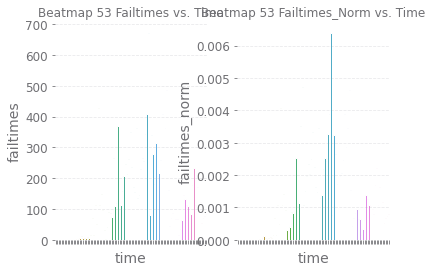

In [9]:
fig, ax =plt.subplots(1,2)

# failtimes bar plot
sns.set(rc={'figure.figsize':(11.7,8.27)})
g = sns.barplot(x = "time", y = "failtimes", data = easy_df.iloc[0:100,:], ax=ax[0])
# plt.figure(figsize=(8,4))
g.set(xticklabels = [], title = 'Beatmap 53 Failtimes vs. Time')

# failtimes norm bar plot
sns.set(rc={'figure.figsize':(11.7,8.27)})
h = sns.barplot(x = "time", y = "failtimes_norm", data = easy_df.iloc[0:100,:], ax=ax[1])
# plt.figure(figsize=(8,4))
h.set(xticklabels = [], title = 'Beatmap 53 Failtimes_Norm vs. Time')

fig.show()

### 2. By Hit Objects

#### Create a dataframe for all beatmaps 
* Each row represents one chunk with at least 2 hit objects
    * i.e., First chunk merges the first 8 intervals and contains 2 hit objects. Second chunk takes the next 3 intervals and contains 3 hit objects, etc.
* All column names are similar to what are in easy_df except that we sum over all objects (average for d_time) within each chunk


In [10]:
min_size = 2
partition_all_df = CREATE_PARTITION_DF(new_beatmaps, easy_df, min_size)
partition_all_df

,num_hit_objects,chunks,failtimes_norm_sum,coord_dist_sum_sum,repeat_count_sum_sum,duration_sum_sum,d_time_avg_avg
0,2,8,0.000000,0.000000,2,0,779.375000
1,3,3,0.000000,0.000000,3,0,581.500000
2,2,3,0.000000,0.000000,2,0,697.666667
3,3,2,0.000038,0.000000,2,0,697.500000
4,2,2,0.000171,0.000000,3,0,697.500000
...,...,...,...,...,...,...,...
31,3,2,0.002323,0.000000,3,0,697.500000
32,3,3,0.002818,243.706791,3,697,698.000000
33,3,5,0.003914,0.000000,4,0,436.000000
34,4,1,0.004885,280.000000,4,697,261.500000


## Model Fitting

### 1. Linear Regression Model

Coefficients for linear regression are [-1.21400249e-08 -2.70770902e-06  5.87454114e-04  4.48740197e-07
 -8.12272155e-08] and the intercept is 0.0017684128253484565
mse for linear regression is 0.0004381433219577658
r^2 for linear regression is 0.00203910167196919


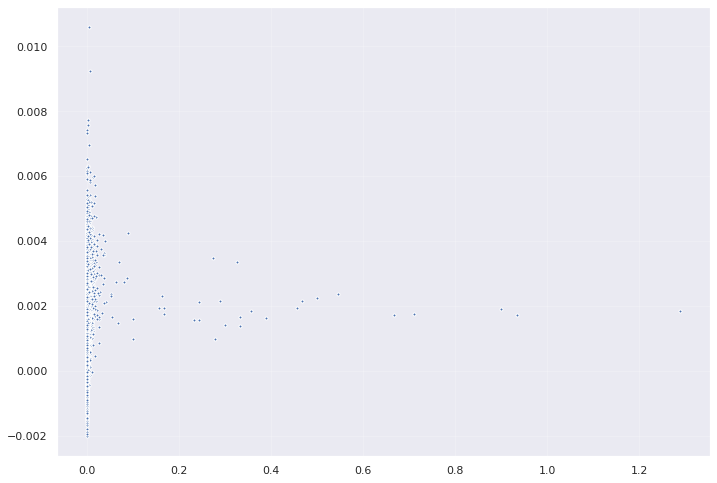

In [11]:
df_for_linearReg = easy_df.dropna()
X = df_for_linearReg[["time", "coord_dist_sum", "repeat_count_sum", "duration_sum", "d_time_avg"]]
y = df_for_linearReg.failtimes_norm
testSize = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = testSize)
 
# train the model
lm = LinearRegression()
lm.fit(X_train, y_train)
 
# return model coefficients
print("Coefficients for linear regression are",lm.coef_, "and the intercept is",lm.intercept_)
 
# plot
y_pred = lm.predict(X_test)
plt.plot(y_test, y_pred, ".")
 
print("mse for linear regression is", mean_squared_error(y_test, y_pred))
print("r^2 for linear regression is",r2_score(y_test, y_pred))

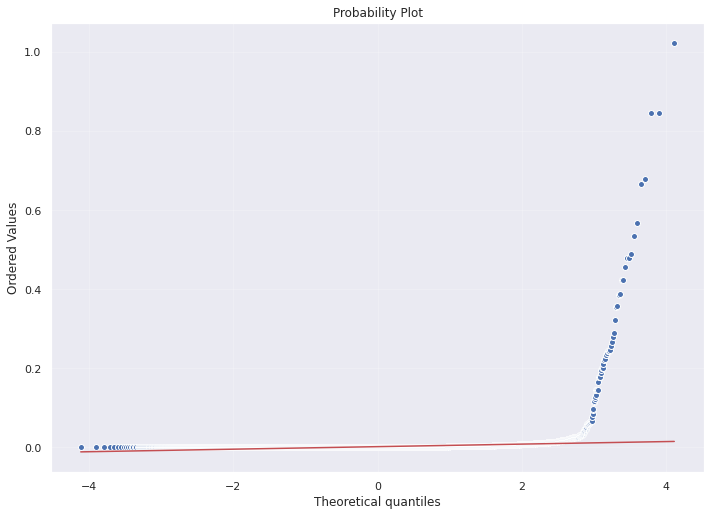

In [12]:
##qq plot
stats.probplot(y_train, dist="norm", plot=pylab)
pylab.show()

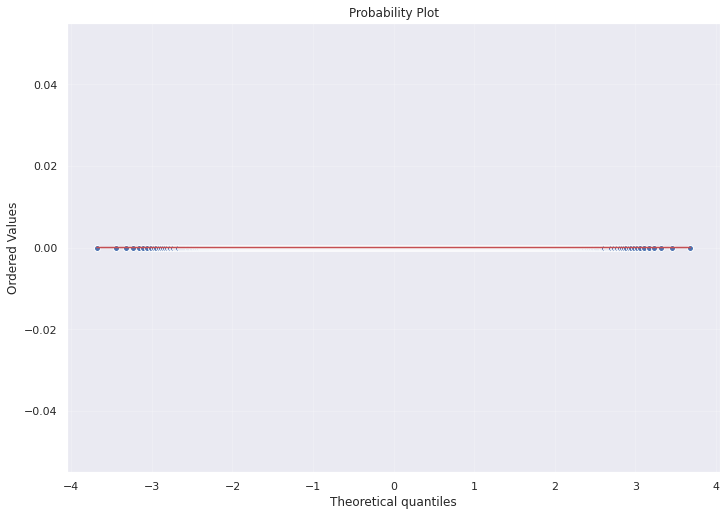

In [13]:
small = np.sort(df_for_linearReg.failtimes_norm)[4000:10000]
stats.probplot(small, dist="norm", plot=pylab)
pylab.show()

We attempted a Linear Regression Model. However, after looking at diagnostic plots, it is clear that our data does fit the assumptions of linear regression. Thus, we will look at another approach.

### 2. KNN Regression Model
We attempted a KNN Regression Model. However, after doing research into the topic, we found that KNN models work best with 2 predictors. Since our data has over 2 predictors, we concluded that the KNN Regression Model was not the right choice for this problem.

### 3. XGBoost Random Forest Regression Model

In [14]:
df_for_XGBoost = partition_all_df
X = df_for_XGBoost[["coord_dist_sum_sum", "repeat_count_sum_sum", "duration_sum_sum", "d_time_avg_avg"]]
y = df_for_XGBoost.failtimes_norm_sum

In [15]:
y_pred_point2, y_test_point2, rmse_percent_point2 = Xgboost_est_pp_model().train_test_model(X, y, 0.2)

/home/ec2-user/.local/share/virtualenvs/dsu-mlpp-LeXi4iVD/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  


In [16]:
rmse_percent_point2

inf

In [17]:
y_pred_vs_real_df_point2 = pd.DataFrame({"y_pred": y_pred_point2, "y_real": y_test_point2})

[Text(0.5, 1.0, 'Beatmap Failtimes Real vs. Predicted'),
 Text(0.5, 0, 'Chunks'),
 Text(0, 0.5, 'Normalized Failtimes')]

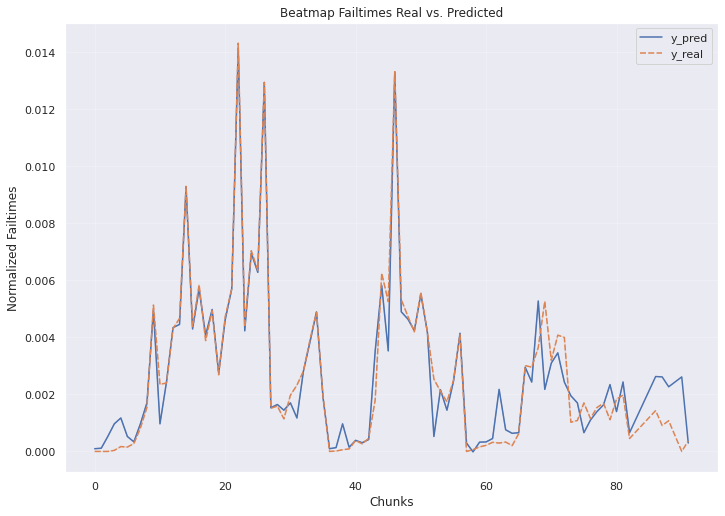

In [18]:
graph = sns.lineplot(data = y_pred_vs_real_df_point2)
graph.set(title = 'Beatmap Failtimes Real vs. Predicted', 
          xlabel='Chunks', ylabel='Normalized Failtimes')

As you can see, the predicted failtimes fits well with the real failtimes using this model.